In [17]:
import librosa
import numpy as np
import soundfile as sf
import tensorflow as tf
import matplotlib.pyplot as plt

In [10]:
SR = 44100
N_FFT = 2048
HOP_LENGTH = 512
WINDOW_SIZE = 128 # Kích thước cửa sổ bạn đã chọn

In [11]:
def separate_audio(audio_path, model, output_dir="results"):
    print(f"Đang xử lý: {audio_path}...")
    
    # 1. Load âm thanh
    y, sr = librosa.load(audio_path, sr=SR)
    
    # 2. STFT
    stft = librosa.stft(y, n_fft=N_FFT, hop_length=HOP_LENGTH)
    mag, phase = librosa.magphase(stft)
    
    # Lưu lại kích thước gốc để lát cắt về đúng size này
    original_length = mag.shape[1]
    
    # 3. Tiền xử lý Shape cho Model
    full_mag = mag[:1024, :] 
    
    # Chuẩn hóa
    max_val = np.max(full_mag)
    if max_val == 0: max_val = 1 # Tránh lỗi chia cho 0
    full_mag_norm = full_mag / max_val
    
    # 4. Padding (Đắp thêm cho đủ chia hết WINDOW_SIZE)
    # CHỈ ĐẮP CHO INPUT CỦA MODEL, KHÔNG ĐẮP CHO PHASE GỐC
    num_frames = full_mag_norm.shape[1]
    pad_width = WINDOW_SIZE - (num_frames % WINDOW_SIZE)
    
    if pad_width < WINDOW_SIZE:
        full_mag_norm = np.pad(full_mag_norm, ((0,0), (0, pad_width)), mode='constant')
        # Lỗi cũ nằm ở đây: Ta đã lỡ tay pad luôn cả phase. 
        # Bây giờ ta KHÔNG pad phase nữa, hoặc dùng biến tạm nếu cần.
        
    # 5. Cắt Chunk
    chunks = []
    num_chunks = full_mag_norm.shape[1] // WINDOW_SIZE
    
    for i in range(num_chunks):
        start = i * WINDOW_SIZE
        end = start + WINDOW_SIZE
        chunk = full_mag_norm[:, start:end]
        chunks.append(chunk[..., np.newaxis])
        
    chunks = np.array(chunks)
    
    # 6. DỰ ĐOÁN
    print("Đang chạy mô hình để tách...")
    predicted_masks = model.predict(chunks, batch_size=16, verbose=1)
    
    # 7. Ghép lại (Concatenate)
    vocal_mask = np.concatenate(predicted_masks, axis=1)
    vocal_mask = vocal_mask.squeeze()
    
    # Bù lại dòng tần số 1025
    vocal_mask = np.pad(vocal_mask, ((0,1), (0,0)), mode='constant')
    
    # --- QUAN TRỌNG: Cắt về đúng kích thước gốc ---
    # Cắt bỏ phần padding thừa lúc nãy để khớp với Phase gốc
    vocal_mask = vocal_mask[:, :original_length]
    
    # 8. Tái tạo âm thanh
    inst_mask = 1.0 - vocal_mask
    
    # Nhân mask với Magnitude gốc
    mag_vocal = mag * vocal_mask
    mag_inst = mag * inst_mask
    
    # Kết hợp với Phase gốc (Phase chưa bị thay đổi kích thước)
    stft_vocal = mag_vocal * phase
    stft_inst = mag_inst * phase
    
    # iSTFT
    y_vocal = librosa.istft(stft_vocal, hop_length=HOP_LENGTH)
    y_inst = librosa.istft(stft_inst, hop_length=HOP_LENGTH)
    
    # 9. Lưu file
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    file_name = os.path.basename(audio_path).split('.')[0]
    vocal_path = os.path.join(output_dir, f"{file_name}_vocal.wav")
    inst_path = os.path.join(output_dir, f"{file_name}_instrumental.wav")
    
    sf.write(vocal_path, y_vocal, SR)
    sf.write(inst_path, y_inst, SR)
    
    print(f"Xong! Đã lưu tại:\n - {vocal_path}\n - {inst_path}")
    return y_vocal, y_inst

In [15]:
def visualize_separation(mix, vocal, inst, sr=44100):
    """
    Hàm vẽ so sánh 3 track: Mix, Vocal, Instrumental
    Input có thể là đường dẫn file (str) hoặc mảng numpy (array)
    """
    
    # 1. Load dữ liệu nếu input là đường dẫn file
    if isinstance(mix, str): mix, _ = librosa.load(mix, sr=sr)
    if isinstance(vocal, str): vocal, _ = librosa.load(vocal, sr=sr)
    if isinstance(inst, str): inst, _ = librosa.load(inst, sr=sr)

    # --- PHẦN 1: WAVEFORM (DẠNG SÓNG) ---
    plt.figure(figsize=(15, 8))
    
    plt.subplot(3, 1, 1)
    librosa.display.waveshow(mix, sr=sr, color='gray', alpha=0.7)
    plt.title("1. Original Mixture (Bản gốc)")
    
    plt.subplot(3, 1, 2)
    librosa.display.waveshow(vocal, sr=sr, color='blue', alpha=0.7)
    plt.title("2. Extracted Vocal (Giọng hát tách được)")
    plt.ylim(plt.ylim()) # Giữ tỉ lệ trục Y giống bản gốc để dễ so sánh
    
    plt.subplot(3, 1, 3)
    librosa.display.waveshow(inst, sr=sr, color='green', alpha=0.7)
    plt.title("3. Extracted Instrumental (Nhạc nền tách được)")
    
    plt.tight_layout()
    plt.show()
    
    # --- PHẦN 2: SPECTROGRAM (QUAN TRỌNG HƠN) ---
    # Chuyển sang Log-Mel Spectrogram để nhìn rõ tần số như mắt người/tai người
    def compute_spec(y):
        # Tính STFT -> Lấy độ lớn -> Chuyển sang dB (Decibel)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
        return D

    specs = [compute_spec(mix), compute_spec(vocal), compute_spec(inst)]
    titles = ["Original Spectrogram", "Vocal Spectrogram", "Instrumental Spectrogram"]
    
    plt.figure(figsize=(15, 6))
    for i, (D, title) in enumerate(zip(specs, titles)):
        plt.subplot(1, 3, i + 1)
        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', cmap='magma')
        plt.title(title)
        plt.colorbar(format='%+2.0f dB')
    
    plt.tight_layout()
    plt.show()

In [12]:
from tensorflow.keras.models import load_model

# 1. Load model đã train
# Thay đường dẫn tới file .keras tốt nhất của bạn
model_path = r"../best_unet_vocal.keras"
model = load_model(model_path)

# 2. Chọn một bài nhạc bất kỳ để test
test_audio = r"..\media_files\separated_audio\Tobenai Tsubasa - Lily Chou-Chou.mp3" # Thay bằng file nhạc của bạn

# 3. Gọi hàm
vocal, inst = separate_audio(test_audio, model)

Đang xử lý: ..\media_files\separated_audio\Tobenai Tsubasa - Lily Chou-Chou.mp3...
Đang chạy mô hình để tách...
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step
Xong! Đã lưu tại:
 - results\Tobenai Tsubasa - Lily Chou-Chou_vocal.wav
 - results\Tobenai Tsubasa - Lily Chou-Chou_instrumental.wav


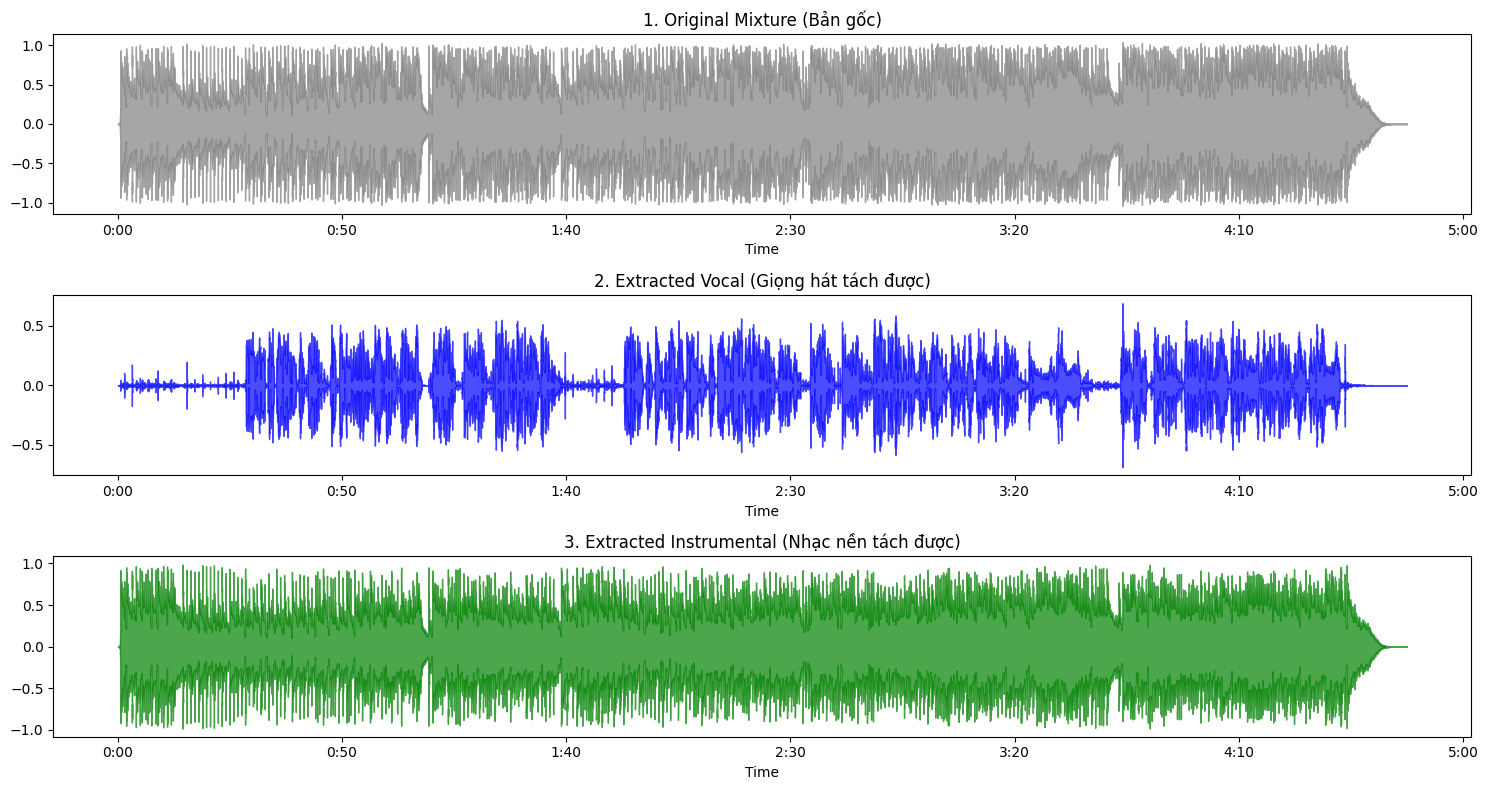

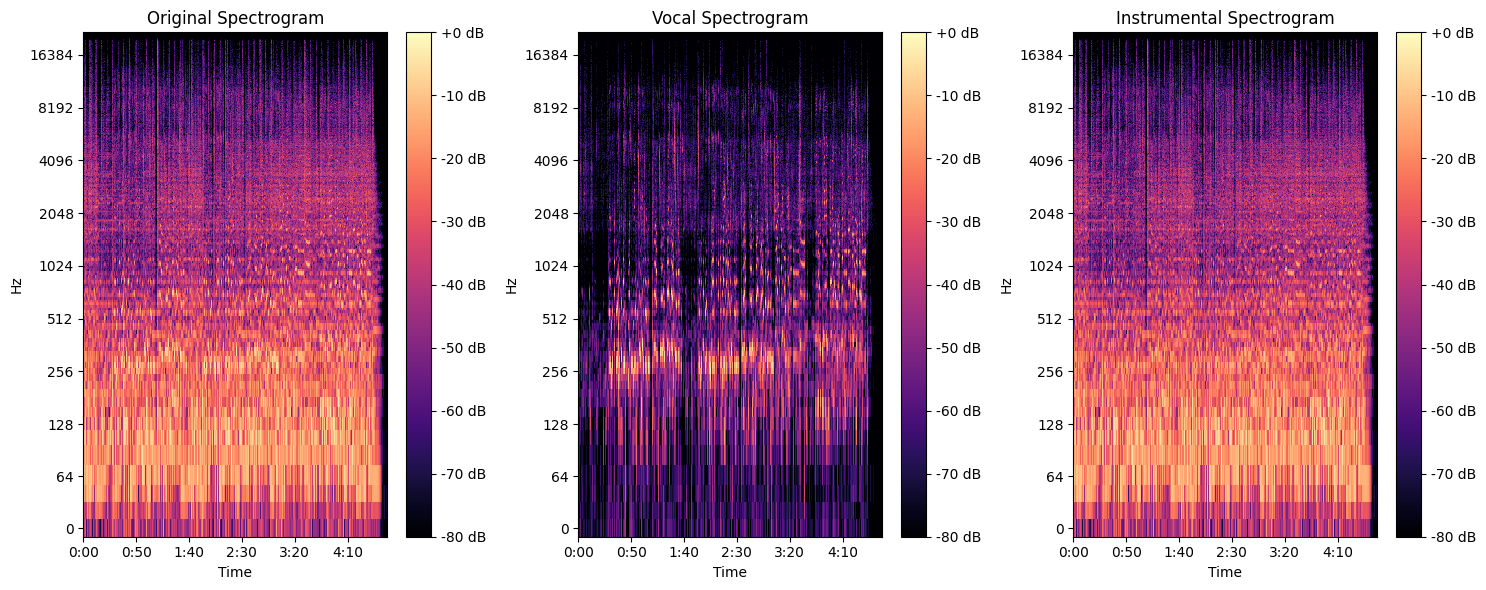

: 

In [ ]:
visualize_separation(test_audio, vocal, inst)